In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch

In [3]:
class LineFollowDataset(Dataset):
    def __init__(
        self, DATASET_PATH, transform=None, train_or_test="train", train_prop=0.90
    ):
        self.DATASET_PATH = DATASET_PATH
        # just load it all into RAM
        self.images = np.load(os.path.join(DATASET_PATH, "imgs.npy"), allow_pickle=True)
        self.actions = np.load(os.path.join(DATASET_PATH, "pts.npy"), allow_pickle=True)
        self.transform = transform
        n_train = int(self.actions.shape[0] * train_prop)
        if train_or_test == "train":
            self.actions = self.actions[:n_train]
        elif train_or_test == "test":
            self.actions = self.actions[n_train:]
        else:
            raise NotImplementedError

        # normalise actions and images to range [0,1]
        # self.actions = self.actions / 500.0
        # self.images = self.images / 255.0

    def __len__(self):
        return self.actions.shape[0]

    def __getitem__(self, index):
        action = self.actions[index] 
        image = self.images[int(action[0])]
        action = action[1:]
        
        if self.transform:
            image = self.transform(image)
        return (image, action)

In [ ]:
DATASET_PATH = "datasets/line_follow/"
tf = transforms.Compose([])

torch_data_train = LineFollowDataset(
        DATASET_PATH, transform=tf, train_or_test="train", train_prop=0.90
    )

In [7]:
from diff_model import (
    Model_cnn_mlp,
    Model_Cond_Diffusion,
)

from sklearn.neighbors import KernelDensity

n_epoch = 100
lrate = 1e-4
device = "cuda"
n_hidden = 512
batch_size = 32
n_T = 50
net_type = "transformer"

# x_shape = torch_data_train.images[0].shape
# y_dim = torch_data_train.actions.shape[1] - 1

x_shape = torch_data_train.images[0].shape
y_dim = torch_data_train.actions.shape[1]

In [8]:
nn_model = Model_cnn_mlp(
    x_shape, n_hidden, y_dim, embed_dim=128, net_type=net_type
).to(device)
model = Model_Cond_Diffusion(
    nn_model,
    betas=(1e-4, 0.02),
    n_T=n_T,
    device=device,
    x_dim=x_shape,
    y_dim=y_dim,
    drop_prob=0.1,
    guide_w=0.0,
)

In [49]:
checkpoint = torch.load("diff_weights/trained_model.pt", weights_only=True)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [10]:
def predict(model, x_eval):
    model.eval()
    use_kde = False
    
    with torch.set_grad_enabled(False):
        # if extra_diffusion_step == 0:
        y_pred_ = (
            model.sample(x_eval, extract_embedding=True)
            .detach()
            .cpu()
            .numpy()
        )

        if use_kde:
            # kde
            torch_obs_many = x_eval
            action_pred_many = model.sample(torch_obs_many).cpu().numpy()
            # fit kde to the sampled actions
            kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(action_pred_many)
            # choose the max likelihood one
            log_density = kde.score_samples(action_pred_many)
            idx = np.argmax(log_density)
            y_pred_ = action_pred_many[idx][None, :]
        else:
            y_pred_ = model.sample_extra(x_eval, extra_steps=16).detach().cpu().numpy()
    
    return y_pred_

In [8]:
x_eval = (
    torch.Tensor(torch_data_train.images[8])
    .type(torch.FloatTensor)
    .to(device)
)

In [9]:
x_eval_ = x_eval.repeat(100, 1, 1, 1)

In [77]:
y = predict(model, x_eval_)

In [78]:
y = y.to_device('cpu')
x_eval = x_eval.detach().cpu()

In [19]:
it = iter(range(50))

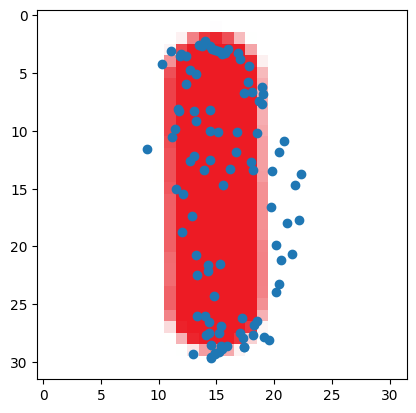

In [81]:
# xp, yp = y[next(it), :]
plt.imshow(x_eval)
plt.scatter(y[:, 0] * 32, y[:, 1] * 32)
# plt.scatter(xp * 32, yp * 32)
plt.savefig('plot.png', bbox_inches = 'tight')

In [2]:
class LineFollowDataset(Dataset):
    def __init__(
        self, DATASET_PATH, transform=None, train_or_test="train", train_prop=0.90
    ):
        self.DATASET_PATH = DATASET_PATH
        # just load it all into RAM
        self.images = np.load(os.path.join(DATASET_PATH, "images.npy"), allow_pickle=True)
        self.actions = np.load(os.path.join(DATASET_PATH, "actions.npy"), allow_pickle=True)
        self.transform = transform
        n_train = int(self.actions.shape[0] * train_prop)
        if train_or_test == "train":
            self.actions = self.actions[:n_train]
        elif train_or_test == "test":
            self.actions = self.actions[n_train:]
        else:
            raise NotImplementedError

        # normalise actions and images to range [0,1]
        # self.actions = self.actions / 500.0
        # self.images = self.images / 255.0

    def __len__(self):
        return self.actions.shape[0]

    def __getitem__(self, index):
        action = self.actions[index] 
        image = self.images[index]
        
        if self.transform:
            image = self.transform(image)
        return (image, action)

In [4]:
DATASET_PATH = "datasets/line_follow/"
tf = transforms.Compose([])

torch_data_train = LineFollowDataset(
        DATASET_PATH, transform=tf, train_or_test="train", train_prop=0.90
    )

In [12]:
import pickle
ids, sts = pickle.load(open("datasets/line_follow/starts.pkl", "rb"))
ids.insert(0, 0)

In [54]:
n = 2

In [55]:
preds = []
for i in range(sum(ids[:n]), sum(ids[:n+1])):
    x_eval = (
        torch.Tensor(torch_data_train.images[i])
        .type(torch.FloatTensor)
        .to(device)
    )
    x_eval_ = x_eval.repeat(1, 1, 1, 1)
    preds.append(np.squeeze(predict(model, x_eval_)))

In [56]:
ppts = np.array(preds)
pptss = np.cumsum(ppts, axis=0)

In [27]:
it = iter(range(84))

(0.7931310665560887, -0.038802601001225415)

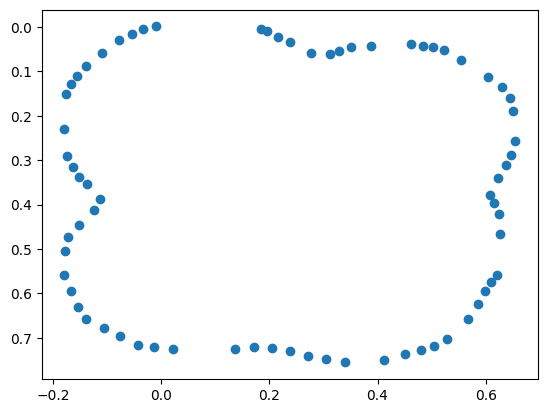

In [57]:
# i = next(it)
plt.scatter(pptss[:, 0], pptss[:, 1])
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
# plt.plot(pptss[:, 0], pptss[:, 1])
# plt.xlim(-0.4, 0.3)
# plt.ylim(-0.01, 0.6)

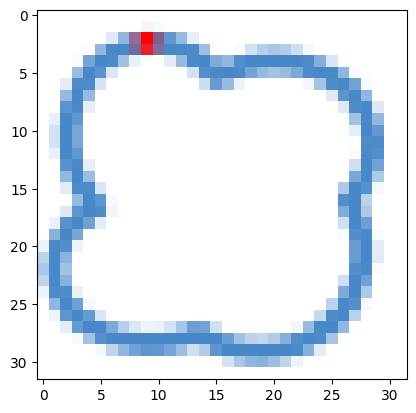

In [59]:
plt.imshow(torch_data_train.images[sum(ids[:n])])

In [ ]:
fig, a

In [38]:
dt = torch_data_train[1]

In [41]:
pt = (dt[1] + st[0]) * 32

In [42]:
pt

array([15.36 ,  3.264])

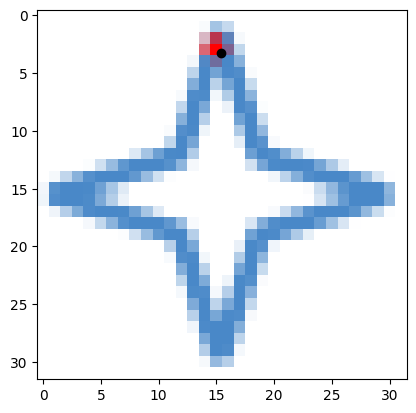

In [45]:
plt.imshow(dt[0])
plt.scatter(pt[0], pt[1], color='k')